# Imports

In [1]:
import keras
import tensorflow as tf

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

import re
import nltk
import gensim

from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.utils import simple_preprocess

from collections import Counter

# Checking GPU

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Dataset Preperation

## Load IMDB Movie Review Dataset

In [4]:
train = pd.read_csv('imdb.csv')

## Examine Dataset

In [5]:
# first samples of IMDB movie reviews dataset 
train.head(15)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
# review text sample
train.loc[0][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
# Dataset lenght
len(train)

50000

In [8]:
# Is there any other sentiment different than pasitive and negative?
train['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [9]:
# Dataset distribition
train.groupby('sentiment').nunique()

,review
sentiment,
negative,24698
positive,24884


In [10]:
# Is there any null value?
train["review"].isnull().sum()

0

In [11]:
# Keep only the columns that we're going to use
train = train[['review','sentiment']]
train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data cleaning process:
* Remove URLs
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* ... etc
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [12]:
def clean_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile('https?://\S+|www\.\S+')
    data = url_pattern.sub('', data)
    # (https?:\/\/) matches http:// or https://
    # (\s)* optional whitespaces
    # (www\.)? optionally matches www.
    # (\s)* optionally matches whitespaces
    # ((\w|\s)+\.)* matches 0 or more of one or more word characters followed by a period
    # ([\w\-\s]+\/)* matches 0 or more of one or more words(or a dash or a space) followed by '\'
    # ([\w\-]+) any remaining path at the end of the url followed by an optional ending
    # ((\?)?[\w\s]*=\s*[\w\%&]*)* matches ending query params (even with white spaces,etc)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # \S* : match as many non-space characters you can
    #  @  : then a @
    # \S* : then another sequence of non-space characters
    # \s? : And eventually a space, if there is one. Note that the '?' is needed to match an address at the end of the line. Because of the greediness of '?', if there is a space, it will always be matched.

    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # (\s+)* 1 or more occurrences of the whitespaces

    # Remove single quotes
    data = re.sub("\'", "", data)
    
    # Remove HTML new line tag
    data = re.sub("<br /><br />", "", data)
    
    return data

In [13]:
temp = []
#Splitting pd.Series to list
data_to_list = train['review'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_data(data_to_list[i]))
list(temp[:5])

['One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'youll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'section', 'of', 'the', 'prison', 'where', 'all', 'the', 'cells', 'have', 'g

In [15]:
len(data_words)

50000

In [16]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [17]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictur

In [18]:
data = np.array(data)

## Label encoding

In [19]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'negative':
        y.append(0)
    if labels[i] == 'positive':
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="float32")
del y

In [20]:
len(labels)

50000

## Data sequencing and splitting

In [21]:
max_words = 5000 # the number of unique words
max_len = 200 # the vector size of the sentences

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
reviews = pad_sequences(sequences, maxlen=max_len) # adding zeros to the sentence's vector
print(reviews)

[[  51   13    4 ...  121 4025  477]
 [   0    0    0 ... 1931   66  217]
 [   0    0    0 ...   61   13  333]
 ...
 [   0    0    0 ... 1685    2    2]
 [   0    0    0 ...   65  727   40]
 [   0    0    0 ...  781    8   14]]


In [22]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [23]:
from sklearn.model_selection import train_test_split
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

37500 12500 37500 12500


# Training RNN and LSTM Models

## Initial Models

### RNN

#### Architecture

In [24]:
model_RNN_1 = Sequential()
model_RNN_1.add(layers.Embedding(max_words, 20))
model_RNN_1.add(layers.SimpleRNN(64))
model_RNN_1.add(layers.Dense(2,activation='softmax'))

model_RNN_1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model_RNN_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                5440      
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 105,570
Trainable params: 105,570
Non-trainable params: 0
_________________________________________________________________


#### Train

In [25]:
H_RNN_1 = model_RNN_1.fit(X_train, y_train, epochs=30, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/30
37/37 [==============================] - 15s 348ms/step - loss: 0.6954 - accuracy: 0.5253 - val_loss: 0.6798 - val_accuracy: 0.5950
Epoch 2/30
37/37 [==============================] - 12s 332ms/step - loss: 0.6321 - accuracy: 0.6571 - val_loss: 0.5753 - val_accuracy: 0.7170
Epoch 3/30
37/37 [==============================] - 12s 329ms/step - loss: 0.4699 - accuracy: 0.7862 - val_loss: 0.4422 - val_accuracy: 0.8002
Epoch 4/30
37/37 [==============================] - 12s 327ms/step - loss: 0.3889 - accuracy: 0.8306 - val_loss: 0.4619 - val_accuracy: 0.8046
Epoch 5/30
37/37 [==============================] - 12s 327ms/step - loss: 0.3502 - accuracy: 0.8493 - val_loss: 0.3733 - val_accuracy: 0.8404
Epoch 6/30
37/37 [==============================] - 12s 328ms/step - loss: 0.3079 - accuracy: 0.8713 - val_loss: 0.3728 - val_accuracy: 0.8423
Epoch 7/30
37/37 [==============================] - 12s 326ms/step - loss: 0.2895 - accuracy: 0.8823 - val_loss: 0.3539 - val_accuracy: 0.8566

##### Save Model

In [26]:
model_RNN_1.save('model_RNN_1.h5')

##### Training Graph

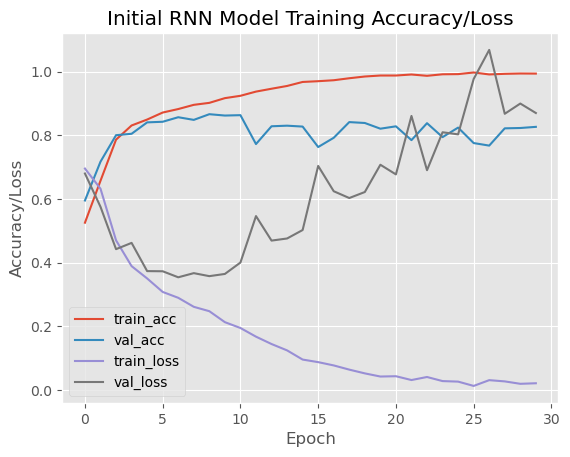

In [27]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_RNN_1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_RNN_1.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, 30), H_RNN_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_RNN_1.history["val_loss"], label="val_loss")
plt.title("Initial RNN Model Training Accuracy/Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

#### Test 

In [28]:
test_loss, test_acc = model_RNN_1.evaluate(X_test,  y_test, verbose=1)

print('\nTest accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.8698 - accuracy: 0.8263

Test accuracy: 0.8263199925422668


##### Confusion Matrix 

In [29]:
predictions = model_RNN_1.predict(X_test, verbose=0)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\Ali\AppData\Local\Temp\ipykernel_8216\2381144012.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


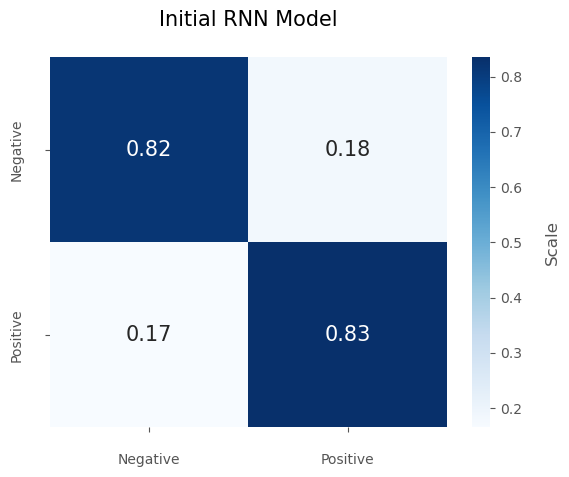

In [30]:
#sns.set(font_scale=5)
conf_matrix = pd.DataFrame(matrix, index = ['Negative\n','Positive\n'],columns = ['\nNegative','\nPositive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize = (5,5))
plt.title('Initial RNN Model\n', fontsize=15)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cbar_kws={'label': '\nScale'}, cmap='Blues')
#plt.close()

### LSTM

#### Architecture

In [31]:
model_LSTM_1 = Sequential()
model_LSTM_1.add(layers.Embedding(max_words, 20))
model_LSTM_1.add(layers.LSTM(64))
model_LSTM_1.add(layers.Dense(2,activation='softmax'))

model_LSTM_1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model_LSTM_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, 64)                21760     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 121,890
Trainable params: 121,890
Non-trainable params: 0
_________________________________________________________________


#### Train

In [32]:
H_LSTM_1 = model_LSTM_1.fit(X_train, y_train, epochs=30, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/30
37/37 [==============================] - 6s 40ms/step - loss: 0.6257 - accuracy: 0.6867 - val_loss: 0.4788 - val_accuracy: 0.7982
Epoch 2/30
37/37 [==============================] - 1s 24ms/step - loss: 0.4504 - accuracy: 0.8033 - val_loss: 0.3926 - val_accuracy: 0.8517
Epoch 3/30
37/37 [==============================] - 1s 24ms/step - loss: 0.3442 - accuracy: 0.8603 - val_loss: 0.3414 - val_accuracy: 0.8632
Epoch 4/30
37/37 [==============================] - 1s 24ms/step - loss: 0.3131 - accuracy: 0.8726 - val_loss: 0.3514 - val_accuracy: 0.8506
Epoch 5/30
37/37 [==============================] - 1s 24ms/step - loss: 0.2818 - accuracy: 0.8870 - val_loss: 0.3785 - val_accuracy: 0.8659
Epoch 6/30
37/37 [==============================] - 1s 24ms/step - loss: 0.2722 - accuracy: 0.8895 - val_loss: 0.3999 - val_accuracy: 0.8562
Epoch 7/30
37/37 [==============================] - 1s 24ms/step - loss: 0.2667 - accuracy: 0.8928 - val_loss: 0.2882 - val_accuracy: 0.8818
Epoch 8/30
37

##### Save Model

In [33]:
model_LSTM_1.save('model_LSTM_1.h5')

##### Training Graph

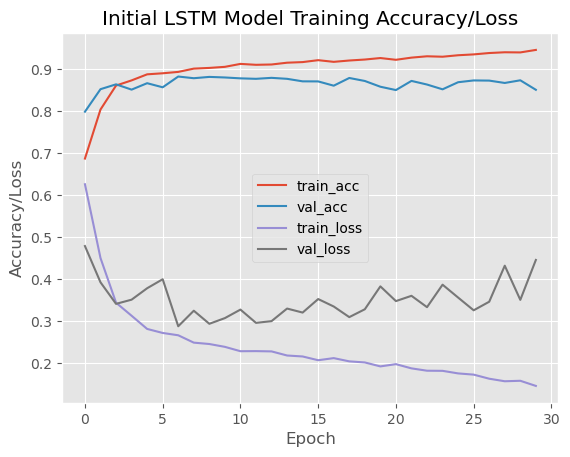

In [34]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_LSTM_1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_LSTM_1.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, 30), H_LSTM_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_LSTM_1.history["val_loss"], label="val_loss")
plt.title("Initial LSTM Model Training Accuracy/Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

#### Test

In [35]:
test_loss, test_acc = model_LSTM_1.evaluate(X_test,  y_test, verbose=1)

print('\nTest accuracy:', test_acc)

391/391 [==============================] - 2s 5ms/step - loss: 0.4458 - accuracy: 0.8502

Test accuracy: 0.8502399921417236


##### Confusion Matrix 

In [36]:
predictions = model_LSTM_1.predict(X_test, verbose=0)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\Ali\AppData\Local\Temp\ipykernel_8216\4142423705.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


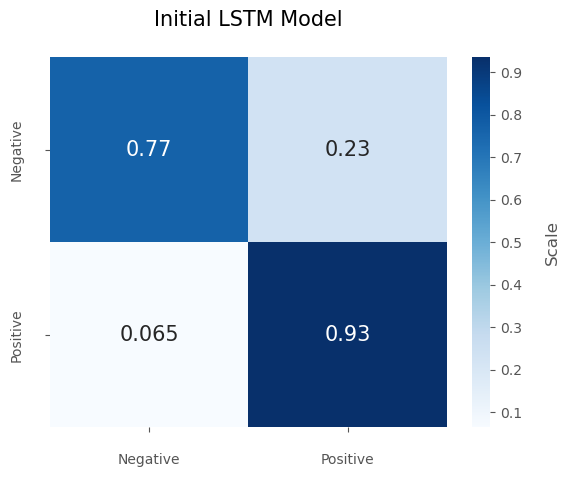

In [37]:
#sns.set(font_scale=5)
conf_matrix = pd.DataFrame(matrix, index = ['Negative\n','Positive\n'],columns = ['\nNegative','\nPositive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize = (5,5))
plt.title('Initial LSTM Model\n', fontsize=15)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cbar_kws={'label': '\nScale'}, cmap='Blues')
#plt.close()

## Final Models

### RNN

#### Architecture

In [38]:
model_RNN_2 = Sequential()
model_RNN_2.add(layers.Embedding(max_words, 15))
model_RNN_2.add(layers.SimpleRNN(15,return_sequences=True,dropout=0.5))
model_RNN_2.add(layers.SimpleRNN(15,dropout=0.3))
model_RNN_2.add(layers.Dense(2,activation='softmax'))

model_RNN_2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train

In [39]:
H_RNN_2 = model_RNN_2.fit(X_train, y_train, epochs=30, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/30
37/37 [==============================] - 33s 858ms/step - loss: 0.7048 - accuracy: 0.5065 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 2/30
37/37 [==============================] - 31s 848ms/step - loss: 0.6900 - accuracy: 0.5351 - val_loss: 0.6833 - val_accuracy: 0.5406
Epoch 3/30
37/37 [==============================] - 31s 848ms/step - loss: 0.6178 - accuracy: 0.6607 - val_loss: 0.5239 - val_accuracy: 0.7370
Epoch 4/30
37/37 [==============================] - 31s 847ms/step - loss: 0.4931 - accuracy: 0.7708 - val_loss: 0.4475 - val_accuracy: 0.7961
Epoch 5/30
37/37 [==============================] - 31s 853ms/step - loss: 0.4352 - accuracy: 0.8100 - val_loss: 0.3859 - val_accuracy: 0.8367
Epoch 6/30
37/37 [==============================] - 31s 852ms/step - loss: 0.3905 - accuracy: 0.8357 - val_loss: 0.3647 - val_accuracy: 0.8474
Epoch 7/30
37/37 [==============================] - 31s 846ms/step - loss: 0.3726 - accuracy: 0.8459 - val_loss: 0.3507 - val_accuracy: 0.8570

##### Save Model

In [40]:
model_RNN_2.save('model_RNN_2.h5')

##### Training Graph

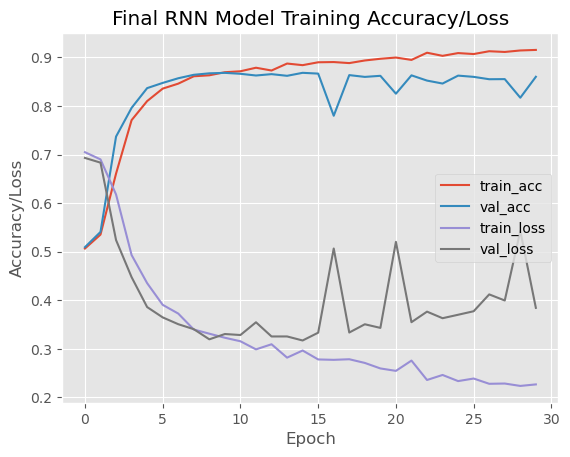

In [41]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_RNN_2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_RNN_2.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, 30), H_RNN_2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_RNN_2.history["val_loss"], label="val_loss")
plt.title("Final RNN Model Training Accuracy/Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

#### Test

In [42]:
test_loss, test_acc = model_RNN_2.evaluate(X_test,  y_test, verbose=1)

print('\nTest accuracy:', test_acc)

391/391 [==============================] - 48s 122ms/step - loss: 0.3843 - accuracy: 0.8601

Test accuracy: 0.8600800037384033


##### Confusion Matrix 

In [43]:
predictions = model_RNN_2.predict(X_test, verbose=0)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\Ali\AppData\Local\Temp\ipykernel_8216\509068928.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


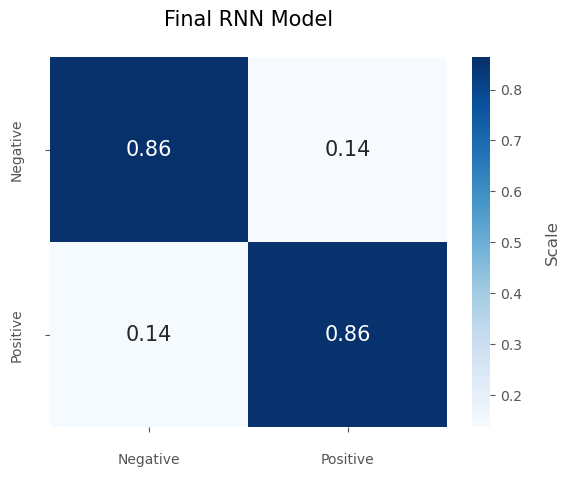

In [44]:
#sns.set(font_scale=5)
conf_matrix = pd.DataFrame(matrix, index = ['Negative\n','Positive\n'],columns = ['\nNegative','\nPositive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize = (5,5))
plt.title('Final RNN Model\n', fontsize=15)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cbar_kws={'label': '\nScale'}, cmap='Blues')
#plt.close()

### LSTM

#### Architecture

In [45]:
model_LSTM_2 = Sequential()
model_LSTM_2.add(layers.Embedding(max_words, 20))
model_LSTM_2.add(layers.LSTM(15,return_sequences=True,dropout=0.5))
model_LSTM_2.add(layers.LSTM(15,dropout=0.3))
model_LSTM_2.add(layers.Dense(2,activation='softmax'))

model_LSTM_2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train

In [46]:
H_LSTM_2 = model_LSTM_2.fit(X_train, y_train, epochs=30, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/30
37/37 [==============================] - 6s 63ms/step - loss: 0.6000 - accuracy: 0.6830 - val_loss: 0.4516 - val_accuracy: 0.8118
Epoch 2/30
37/37 [==============================] - 1s 41ms/step - loss: 0.4231 - accuracy: 0.8125 - val_loss: 0.3785 - val_accuracy: 0.8422
Epoch 3/30
37/37 [==============================] - 1s 40ms/step - loss: 0.3621 - accuracy: 0.8479 - val_loss: 0.3389 - val_accuracy: 0.8586
Epoch 4/30
37/37 [==============================] - 1s 40ms/step - loss: 0.3307 - accuracy: 0.8627 - val_loss: 0.3253 - val_accuracy: 0.8669
Epoch 5/30
37/37 [==============================] - 1s 40ms/step - loss: 0.3120 - accuracy: 0.8727 - val_loss: 0.3071 - val_accuracy: 0.8750
Epoch 6/30
37/37 [==============================] - 1s 39ms/step - loss: 0.2901 - accuracy: 0.8838 - val_loss: 0.3339 - val_accuracy: 0.8572
Epoch 7/30
37/37 [==============================] - 1s 39ms/step - loss: 0.2777 - accuracy: 0.8899 - val_loss: 0.3182 - val_accuracy: 0.8663
Epoch 8/30
37

##### Save Model

In [47]:
model_LSTM_2.save('model_LSTM_2.h5')

##### Training Graph

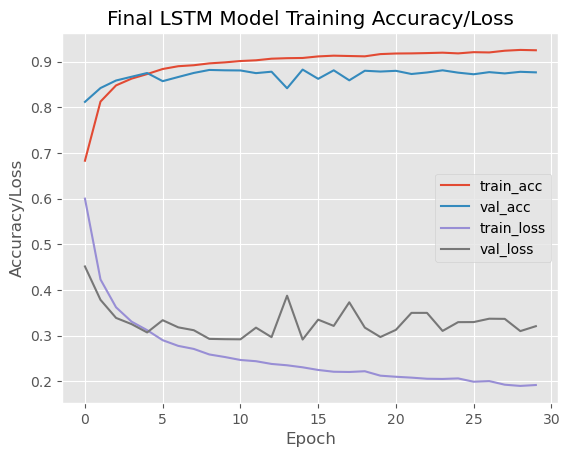

In [48]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_LSTM_2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_LSTM_2.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, 30), H_LSTM_2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_LSTM_2.history["val_loss"], label="val_loss")
plt.title("Final LSTM Model Training Accuracy/Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

#### Test

In [49]:
test_loss, test_acc = model_LSTM_2.evaluate(X_test,  y_test, verbose=1)

print('\nTest accuracy:', test_acc)

391/391 [==============================] - 3s 7ms/step - loss: 0.3208 - accuracy: 0.8765

Test accuracy: 0.876479983329773


##### Confusion Matrix 

In [50]:
predictions = model_LSTM_2.predict(X_test, verbose=0)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\Ali\AppData\Local\Temp\ipykernel_8216\77495835.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


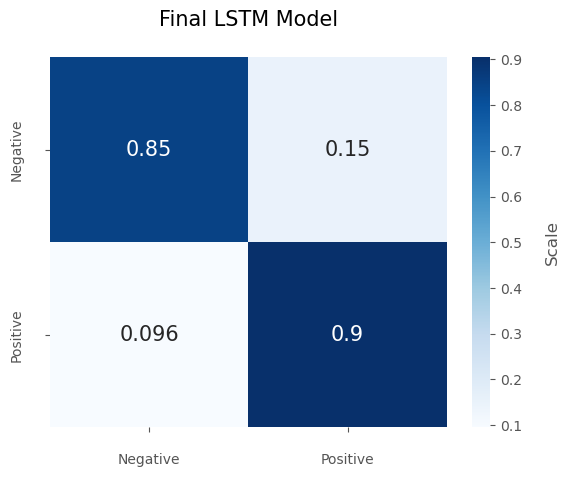

In [51]:
#sns.set(font_scale=5)
conf_matrix = pd.DataFrame(matrix, index = ['Negative\n','Positive\n'],columns = ['\nNegative','\nPositive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize = (5,5))
plt.title('Final LSTM Model\n', fontsize=15)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cbar_kws={'label': '\nScale'}, cmap='Blues')
#plt.close()